### Analisis exploratorio de datos

In [1]:
#Librerias
import pandas as pd
import numpy as np
from google.cloud import bigquery
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

In [2]:
from google.colab import auth
auth.authenticate_user()
project_id = "prello-project-434904"

### Queries

In [3]:
query_population = """
  SELECT *
  FROM `prello-project-434904.prello.population_by_municipality`
"""

In [4]:
query_salary = """
  SELECT *
  FROM `prello-project-434904.prello.average_salary_by_municipality`
"""

In [5]:
query_housing = """
  SELECT *
  FROM `prello-project-434904.prello.housing_stock`
"""

In [6]:
query_price = """
  SELECT *
  FROM `prello-project-434904.prello.real_estate_info_by_municipality`
"""

In [7]:
query_establishments = """
  SELECT *
  FROM `prello-project-434904.prello.POI_tourist_establishments`
"""

In [8]:
query_sites = """
  SELECT *
  FROM `prello-project-434904.prello.POI_touristic_sites_by_municipality`
"""

In [9]:
query_sales = """
  SELECT *
  FROM `prello-project-434904.prello.notary_real_estate_sales`
"""

## Analisis exploratorio por cada tabla

## Population

In [10]:
df_population = pd.read_gbq(query_population,project_id)
df_population.head()

<ipython-input-10-baa28e26f8fd>:1: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  df_population = pd.read_gbq(query_population,project_id)


,municipality_code,year,population,country_code
0,04213,1968,0.0,01
1,05137,1968,0.0,01
2,55039,1968,0.0,01
3,55050,1968,0.0,01
4,55239,1968,0.0,01


In [11]:
pop_min = df_population['year'].min()
pop_max = df_population['year'].max()
pop_n = df_population['year'].nunique()
print(f"La evolución de la población abarca {pop_n} años" \
      f" entre: {pop_min} y {pop_max}")

La evolución de la población abarca 19 años entre: 1968 y 2019


In [12]:
df_population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689495 entries, 0 to 689494
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   municipality_code  689495 non-null  object 
 1   year               689495 non-null  Int64  
 2   population         689495 non-null  float64
 3   country_code       689495 non-null  object 
dtypes: Int64(1), float64(1), object(2)
memory usage: 21.7+ MB


In [13]:
Population_zero = df_population.groupby(['year']).apply(
    lambda x:(x['population']==0).sum()).reset_index()
Population_zero.columns = ["year","nb_obs"]
Population_zero.T

<ipython-input-13-64be9e1eae61>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Population_zero = df_population.groupby(['year']).apply(


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
year,1968,1975,1982,1990,1999,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
nb_obs,6,4,4,5,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6


In [14]:
quartiles_by_year = df_population.groupby("year")["population"].quantile(
    [0.25, 0.5, 0.75]).unstack().dropna().reset_index()
quartiles_by_year.columns=["year","Q_25","Q_50","Q_75"]
quartiles_by_year.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
year,1968,1975,1982,1990,1999,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Q_25,170.0,165.0,169.0,172.0,176.0,187.0,189.0,191.0,193.0,194.0,195.0,196.0,196.0,198.0,198.0,198.0,199.0,198.0,198.0
Q_50,332.0,334.0,350.0,367.0,382.0,411.0,416.0,421.0,426.0,430.0,433.0,435.0,437.0,444.0,450.0,451.0,457.0,457.0,457.0
Q_75,713.0,752.0,819.0,895.0,938.0,1014.0,1026.0,1041.0,1051.0,1061.0,1070.5,1077.0,1086.0,1112.0,1133.0,1139.0,1157.25,1157.0,1160.0


Valores inusualmente bajos, se observa que el  25 % de la población
esta por debajo 190 habitantes, de igual forma en el tercer quartil (0.75) la la linea es por debajo de los 1000 habitantes

In [16]:
df_population = df_population.sort_values(by=['municipality_code', 'year'])
df_population['population_growth'] = df_population.groupby(
                                  'municipality_code')['population'
                                  ].pct_change()*100

In [17]:
filtro = df_population[df_population['year'] == 2019]
pop_lastyear = filtro[['municipality_code','population','population_growth']]

fig_population = go.Figure()

fig_population.add_trace(go.Histogram(histfunc="sum", y=pop_lastyear['population'],
                           x=pop_lastyear['municipality_code'],
                           name='population'))


fig_population.update_layout(title='Evolución de la densidad poblacional por codigo de municipalidad, Francia - 2019')

fig_population.show()

La variabilidad en las dimensiones de la población dificulta el análisis. Dado el objetivo de identificar ciudades con mayor potencial de desarrollo, el estudio debe enfocarse en ciudades con más de 50K habitantes, evaluando las variaciones poblacionales respecto al periodo anterior.

In [18]:
fig_population_growth = px.scatter(pop_lastyear,
                 x=pop_lastyear['population'],
                 y=pop_lastyear['population_growth'],
                 color="population_growth",
                 trendline="ols",
                 marginal_x="histogram",
                 marginal_y="box"
)

fig_population_growth.update_layout(title='Distribución de la densidad publación y crecimiento poblacional por codigo municipalidad, Francia -2019')

fig_population_growth.show()

Output hidden; open in https://colab.research.google.com to view.

##Salary

In [19]:
df_salary = pd.read_gbq(query_salary,project_id)
df_salary.head()

<ipython-input-19-644365b67214>:1: FutureWarning:

read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq



,municipality_code,avg_net_salary,year,country_code
0,01004,26471.026727,2019,01
1,01007,26341.353419,2019,01
2,01014,25897.497842,2019,01
3,01024,25695.240341,2019,01
4,01025,26054.712323,2019,01


In [20]:
pyear_min = df_salary['year'].min()
pyear_max = df_salary['year'].max()
pyear_n = df_salary['year'].nunique()

print(f"La evolución del salario abarca {pyear_n} años" \
      f" entre: {pyear_min} y {pyear_max}")

La evolución del salario abarca 5 años entre: 2015 y 2019


In [21]:
df_salary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26675 entries, 0 to 26674
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   municipality_code  26675 non-null  object 
 1   avg_net_salary     26675 non-null  float64
 2   year               26675 non-null  Int64  
 3   country_code       26675 non-null  object 
dtypes: Int64(1), float64(1), object(2)
memory usage: 859.8+ KB


In [22]:
salary_lastyear = df_salary[df_salary['year']==2019]
salary_lastyear = salary_lastyear[['municipality_code','avg_net_salary']]

fig_salario = go.Figure()

fig_salario.add_trace(go.Histogram(histfunc="sum",
                             y=salary_lastyear['avg_net_salary'],
                             x=salary_lastyear['municipality_code']
                             ))

fig_salario.update_layout(title='Evolución del salario promedio anual por codigo de municipalidad, Francia - 2019')

fig_salario.show()

In [23]:
salary_lastyear.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
avg_net_salary,5395.0,27034.86,5369.76,19435.02,23733.82,25607.09,28554.21,85814.08


In [26]:
salary_lastyear['municipality_code'].drop_duplicates()
salary_lastyear.shape

(5395, 2)

## Housing

In [28]:
df_housing = pd.read_gbq(query_housing,project_id)
df_housing.head()

<ipython-input-28-f859f054abe9>:1: FutureWarning:

read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq



,int64_field_0,municipality_code,year,nb_principal_home,nb_second_home,nb_vacants_housing,nb_tot_housing,secondary_home_rate,principal_home_rate,vacants_housing_rate,country_code
0,25,01339,1968,109,155,0,264,0.587121,0.412879,0.0,1
1,89,02368,1968,132,56,0,188,0.297872,0.702128,0.0,1
2,203,04073,1968,134,93,0,227,0.409692,0.590308,0.0,1
3,238,04148,1968,42,93,0,135,0.688889,0.311111,0.0,1
4,270,05012,1968,70,53,0,123,0.430894,0.569106,0.0,1


In [29]:
hyear_min = df_housing['year'].min()
hyear_max = df_housing['year'].max()
hyear_n = df_housing['year'].nunique()

print(f"La evolución de las variables abarca {hyear_n} años" \
      f" entre: {hyear_min} y {hyear_max}")

La evolución de las variables abarca 8 años entre: 1968 y 2018


In [30]:
df_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279584 entries, 0 to 279583
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   int64_field_0         279584 non-null  Int64  
 1   municipality_code     279584 non-null  object 
 2   year                  279584 non-null  Int64  
 3   nb_principal_home     279584 non-null  Int64  
 4   nb_second_home        279584 non-null  Int64  
 5   nb_vacants_housing    279584 non-null  Int64  
 6   nb_tot_housing        279584 non-null  Int64  
 7   secondary_home_rate   279584 non-null  float64
 8   principal_home_rate   279584 non-null  float64
 9   vacants_housing_rate  279584 non-null  float64
 10  country_code          279584 non-null  Int64  
dtypes: Int64(7), float64(3), object(1)
memory usage: 25.3+ MB


In [31]:
availability_lastyear = df_housing[df_housing['year']==2018]
availability_lastyear = availability_lastyear[['municipality_code',
                                            'nb_second_home',
                                            'vacants_housing_rate',
                                            'nb_tot_housing','nb_vacants_housing']]
availability_lastyear.describe().T

,count,mean,std,min,25%,50%,75%,max
nb_second_home,34948.0,100.530188,917.88167,0.0,7.0,19.0,51.0,128408.0
vacants_housing_rate,34948.0,0.086911,0.047293,0.0,0.054167,0.079365,0.112245,1.0
nb_tot_housing,34948.0,1036.376588,9153.116569,0.0,119.0,252.0,607.0,1386846.0
nb_vacants_housing,34948.0,84.519171,787.204537,0.0,9.0,20.0,49.0,117666.0


In [32]:
availability_lastyear['municipality_code'].drop_duplicates()
availability_lastyear.shape

(34948, 5)

## Price

In [33]:
df_price = pd.read_gbq(query_price,project_id)
df_price.head()

<ipython-input-33-4dc695415ccb>:1: FutureWarning:

read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq



,municipality_code,intensite_tension_immo,rental_max_apartment,rental_min_apartment,rental_med_house,rental_max_house,rental_min_house,rental_med_all,rental_max_all,rental_min_all
0,57133,8,12.27,9.07,9.19,14.45,6.64,9.53,13.77,7.25
1,57446,8,18.22,7.69,10.92,14.16,7.77,11.09,15.97,7.73
2,77013,9,18.30,8.39,12.20,16.71,9.21,12.26,16.75,9.19
3,77026,9,15.76,6.28,9.51,13.20,7.04,9.53,13.23,7.03
4,77072,9,17.50,7.69,11.47,15.75,8.21,11.47,15.75,8.21


In [34]:
price_join = df_price[['municipality_code',
                       'rental_max_all',
                       'rental_min_all',
                       'rental_med_all',
                       'rental_max_house',
                       'rental_min_house',
                       'rental_med_house',
                       'rental_max_apartment',
                       'rental_min_apartment']]
price_join.describe().T

,count,mean,std,min,25%,50%,75%,max
rental_max_all,34441.0,13.746826,3.348301,7.30,11.60,13.08,15.03,45.46
rental_min_all,34441.0,7.355064,1.666057,3.98,6.33,7.00,7.95,27.81
rental_med_all,34441.0,10.190045,2.213078,6.07,8.79,9.70,10.98,34.81
rental_max_house,34421.0,13.424505,3.178939,7.12,11.42,12.81,14.50,41.63
rental_min_house,34421.0,7.375303,1.716441,3.82,6.32,7.01,7.98,22.55
rental_med_house,34421.0,10.179351,2.281479,6.04,8.78,9.66,10.90,29.41
rental_max_apartment,34441.0,15.878574,3.555982,7.55,13.62,15.42,17.70,45.46
rental_min_apartment,34441.0,7.462678,1.599958,4.10,6.40,7.13,8.23,27.81


In [35]:
price_join['municipality_code'].drop_duplicates()
price_join.shape

(34441, 9)

## Establishments

In [36]:
df_establishments = pd.read_gbq(query_establishments,project_id)
df_establishments.head()

<ipython-input-36-87013bdf60ce>:1: FutureWarning:

read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq



,poi,name,latitude,longitude,municipality_code,importance,name_reprocessed
0,hotel,Club Med (Hôtel),45.678531,-1.163635,17225,0.078556,Club Med
1,hotel,Cabanes des Grands Cépages (Hôtel),44.026859,4.847491,84129,0.078419,Cabanes des Grands Cépages
2,hotel,Pierre et Vacances (Hôtel),50.331541,1.565677,80333,0.077999,Pierre et Vacances
3,hotel,Pierre & Vacances (Hôtel),43.285936,6.569696,83068,0.077702,Pierre & Vacances
4,hotel,Le Domaine du Golf (Hôtel),43.541050,3.752852,34095,0.077542,Le Domaine du Golf


In [37]:
df_establishments['poi'].unique()

array(['hotel', 'hostel', 'camp_site', 'guest_house', 'bed_and_breakfast'],
      dtype=object)

In [38]:
establishments_join = df_establishments.groupby(['municipality_code'])['importance'].sum().reset_index()
establishments_join.columns = ['municipality_code','establishments_importance']
establishments_join.describe().T

,count,mean,std,min,25%,50%,75%,max
establishments_importance,8828.0,0.154519,0.809335,0.03,0.05,0.064382,0.129306,70.275305


In [39]:
establishments_join['municipality_code'].drop_duplicates()
establishments_join.shape

(8828, 2)

##Sites

In [40]:
df_sites = pd.read_gbq(query_sites,project_id)
df_sites.head()

<ipython-input-40-5e3a5fda866a>:1: FutureWarning:

read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq



,poi,name,latitude,longitude,municipality_code,importance,name_reprocessed
0,1,Fortifications de Vauban (Patrimoine mondial),46.396160,1.472600,36134,0.139527,Fortifications de Vauban
1,1,Chemins de Saint-Jacques-de-Compostelle en Fra...,46.313695,1.478772,23258,0.137821,Chemins de Saint-Jacques-de-Compostelle en Fra...
2,1,Canal du Midi (Patrimoine mondial),43.332709,3.219890,34032,0.129531,Canal du Midi
3,1,Bassin minier du Nord-Pas de Calais (Patrimoin...,50.455895,2.965034,62427,0.127170,Bassin minier du Nord-Pas de Calais
4,1,"Les Causses et les Cévennes, paysage culturel ...",44.346210,3.613406,48050,0.124981,"Les Causses et les Cévennes, paysage culturel ..."


In [41]:
df_sites['poi'].unique()

array(['1', '2', 'zoo', 'dune', 'park', 'rock', 'sand', 'beach', 'cliff',
       'islet', 'ridge', 'water', 'wreck', 'casino', 'castle', 'cinema',
       'forest', 'geyser', 'marina', 'meadow', 'museum', 'valley',
       'theatre', 'volcano', 'wetland', 'heritage', 'monument',
       'vineyard', 'viewpoint', 'waterfall', 'allotments', 'attraction',
       'theme_park', 'water_park', 'golf_course', 'cave_entrance',
       'national_park', 'protected_area'], dtype=object)

In [42]:
sites_join = df_sites.groupby(['municipality_code'])[
            'importance'].sum().reset_index()

sites_join.columns = ['municipality_code','sites_importance']
sites_join.describe().T

,count,mean,std,min,25%,50%,75%,max
sites_importance,12019.0,0.174963,0.484089,0.05,0.065181,0.086476,0.169802,39.776472


In [45]:
sites_join['municipality_code'].drop_duplicates()
sites_join.shape

(12019, 2)

##Sales

In [46]:
df_sales = pd.read_gbq(query_sales,project_id)
df_sales.head()

<ipython-input-46-8a602c33af5e>:1: FutureWarning:

read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq



,sales_date,sales_amount,street_number,street_code,street_name,nom_commune,municipality_code,premise_type,surface,number_of_principal_rooms,sales_price_m2,latitude,longitude
0,2018-02-06,5000000.0,63.0,0040,AV PRINCE RAINIER III,Saint-Jean-Cap-Ferrat,06121,Maison,292.0,10,17123.0,43.678892,7.330651
1,2018-11-26,93060.0,5308.0,B061,LE SERRET,Vallées-d'Antraigues-Asperjoc,07011,Maison,16.0,0,5816.0,44.714072,4.360185
2,2018-06-08,95000.0,161.0,0683,IMP COL EMILE VIGUIER,Millau,12145,Maison,21.0,0,4524.0,44.093714,3.054594
3,2018-07-17,3912000.0,690.0,1868,CHE DE MAZARGUES,Aix-en-Provence,13001,Maison,610.0,13,6413.0,43.502833,5.428194
4,2018-03-27,810000.0,5000.0,0162,CHE DES OLIVIERS,Eygalières,13034,Maison,296.0,9,2736.0,43.756881,4.957214


In [51]:
df_sales['premise_type'].unique()

array(['Maison', 'Appartement'], dtype=object)

In [52]:
df_sales['sales_date'] = pd.to_datetime(df_sales['sales_date'])
df_sales['year'] = (df_sales['sales_date'].dt.year).astype('Int64')

In [53]:
syear_min = df_sales['year'].min()
syear_max = df_sales['year'].max()
syear_n = df_sales['year'].nunique()

print(f"La evolución de las variables abarca {syear_n} años" \
      f" entre: {syear_min} y {syear_max}")

La evolución de las variables abarca 5 años entre: 2017 y 2021


In [55]:
sales_lastyear = df_sales[df_sales['year'] == 2021].copy()

# agregar columnas de total ventas por house y appartement
sales_lastyear['house_amount'] =  sales_lastyear['sales_amount'][sales_lastyear['premise_type'] == 'Maison']
sales_lastyear['appartement_amount'] = sales_lastyear['sales_amount'][sales_lastyear['premise_type'] == 'Appartement']

# agregar columnas de precio por m2 por house y appartement
sales_lastyear['house_sales_m2'] =  sales_lastyear['sales_price_m2'][sales_lastyear['premise_type'] == 'Maison']
sales_lastyear['appartement_sales_m2'] = sales_lastyear['sales_price_m2'][sales_lastyear['premise_type'] == 'Appartement']

# agregar columnas de dimensiones en m2 por house, appartement y general
sales_lastyear['size_m2'] = sales_lastyear['sales_amount'] / sales_lastyear['sales_price_m2']
sales_lastyear['house_size_m2'] = sales_lastyear['house_amount'] / sales_lastyear['house_sales_m2']
sales_lastyear['appartement_size_m2'] = sales_lastyear['appartement_amount'] / sales_lastyear['appartement_sales_m2']

sales_lastyear = sales_lastyear[['municipality_code','sales_amount',
                                 'sales_price_m2','house_amount',
                                 'appartement_amount','house_sales_m2',
                                 'appartement_sales_m2','size_m2',
                                 'house_size_m2','appartement_size_m2']]

In [57]:
sales_join = sales_lastyear.groupby(['municipality_code']).agg({'sales_amount':["count","sum"],"sales_price_m2":"mean","size_m2":"median",
                                                                'house_amount':["count","sum"],"house_sales_m2":"mean","house_size_m2":"median",
                                                                'appartement_amount':["count","sum"],"appartement_sales_m2":"mean","appartement_size_m2":"median"}).reset_index()

sales_join.columns = ["municipality_code","n_sales","total_amount","avg_price_m2","med_size_m2",
                      "n_house","total_amount_house","house_avg_price_m2","house_med_size_m2",
                      "n_appartement","total_amount_appartement","appartement_avg_price_m2","appartement_med_size_m2"]

sales_join.drop_duplicates()
sales_join.shape

(31172, 13)

### Modelo

In [58]:
modelo = pop_lastyear

for df in [salary_lastyear,
           availability_lastyear,
           price_join, establishments_join,
           sites_join,
           sales_join]:
    modelo = pd.merge(modelo, df, on='municipality_code', how='left')
modelo = modelo.set_index('municipality_code')
modelo.head()

,population,population_growth,avg_net_salary,nb_second_home,vacants_housing_rate,nb_tot_housing,nb_vacants_housing,rental_max_all,rental_min_all,rental_med_all,...,avg_price_m2,med_size_m2,n_house,total_amount_house,house_avg_price_m2,house_med_size_m2,n_appartement,total_amount_appartement,appartement_avg_price_m2,appartement_med_size_m2
municipality_code,,,,,,,,,,,,,,,,,,,,,
01001,779.0,1.037613,NaN,16,0.073654,353,26,13.76,7.53,10.66,...,2570.642857,121.502869,14.0,4264290.0,2570.642857,121.502869,0.0,0.00,NaN,NaN
01002,256.0,1.185771,NaN,53,0.091954,174,16,13.90,8.11,10.16,...,2878.571429,109.997556,4.0,941300.0,1867.500000,105.017007,3.0,1350000.00,4226.666667,109.997556
01004,14134.0,-0.492819,26471.026727,119,0.094252,7342,692,16.49,8.19,11.25,...,2388.303754,81.001473,161.0,38663975.0,2442.006211,91.020721,132.0,18967400.65,2322.803030,65.002600
01005,1751.0,1.802326,NaN,5,0.076227,774,59,18.27,9.77,13.28,...,3169.560000,94.992556,20.0,7133057.0,3182.300000,101.505512,5.0,1278570.00,3118.600000,67.994172
01006,112.0,0.000000,NaN,12,0.120000,75,9,17.82,9.20,12.70,...,1948.000000,103.016924,4.0,647800.0,1653.750000,87.503455,3.0,490000.00,2340.333333,103.016924


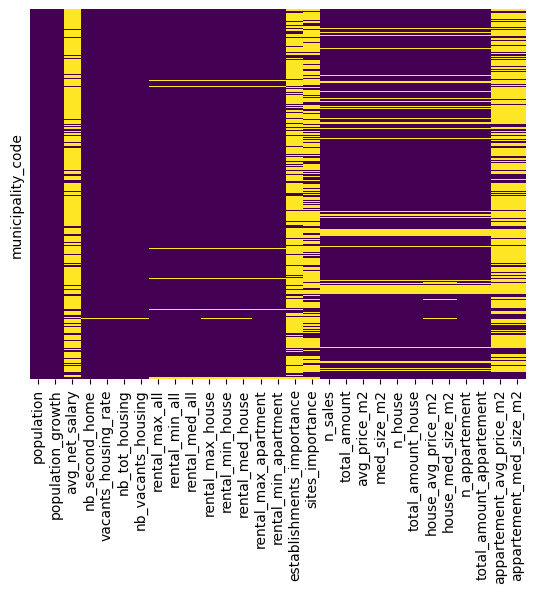

In [59]:
sns.heatmap(modelo.isnull(),yticklabels=False,cbar=False,cmap='viridis');

In [60]:
modelo.isnull().sum()

,0
population,0
population_growth,6
avg_net_salary,29602
nb_second_home,24
vacants_housing_rate,24
nb_tot_housing,24
nb_vacants_housing,24
rental_max_all,556
rental_min_all,556
rental_med_all,556


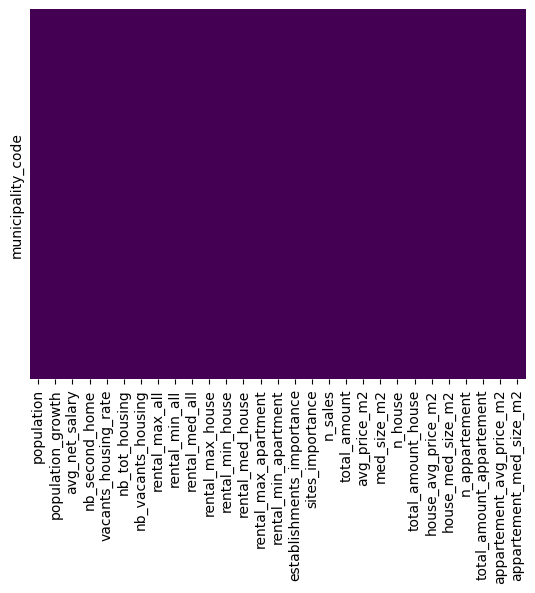

In [61]:
modelo = modelo.dropna()
sns.heatmap(modelo.isnull(),yticklabels=False,cbar=False,cmap='viridis');

In [62]:
modelo.describe()

,population,population_growth,avg_net_salary,nb_second_home,vacants_housing_rate,nb_tot_housing,nb_vacants_housing,rental_max_all,rental_min_all,rental_med_all,...,avg_price_m2,med_size_m2,n_house,total_amount_house,house_avg_price_m2,house_med_size_m2,n_appartement,total_amount_appartement,appartement_avg_price_m2,appartement_med_size_m2
count,2201.000000,2201.000000,2201.000000,2201.0,2201.000000,2201.0,2201.0,2201.000000,2201.000000,2201.000000,...,2201.000000,2201.000000,2201.000000,2.201000e+03,2201.000000,2201.000000,2201.000000,2.201000e+03,2201.000000,2201.000000
mean,14037.786461,0.408564,26865.771006,763.565198,0.083483,7871.372558,631.980918,17.326065,8.648910,12.197483,...,2915.271962,82.428050,119.171286,3.986173e+07,3087.323566,98.547648,154.596093,3.131550e+07,2933.260519,58.885482
std,26601.621630,1.367366,5461.634621,2167.401372,0.042171,15432.112178,1429.212434,5.078764,2.510594,3.348384,...,1580.738223,16.743003,135.801641,6.228115e+07,2017.525354,15.648901,450.304382,1.055026e+08,1456.000317,15.151392
min,1970.000000,-6.141847,19435.024824,2.0,0.000350,841.0,4.0,8.920000,5.090000,7.250000,...,767.406780,26.000693,2.000000,7.015700e+05,760.250000,33.000000,1.000000,2.200000e+04,426.125000,18.000000
25%,3370.000000,-0.374150,23485.724379,59.0,0.052980,1978.0,146.0,13.790000,6.930000,9.840000,...,1846.322581,71.989529,48.000000,1.106485e+07,1822.267442,89.993476,11.000000,1.618690e+06,1914.666667,50.000569
50%,6007.000000,0.261572,25247.238608,145.0,0.075014,3475.0,264.0,15.880000,7.870000,11.220000,...,2505.786667,82.521629,81.000000,2.103492e+07,2545.350993,96.006067,35.000000,5.035130e+06,2617.714286,59.003267
75%,13381.000000,1.049911,28408.804829,425.0,0.107938,7719.0,570.0,19.390000,9.720000,13.510000,...,3613.513011,91.994835,137.000000,4.350188e+07,3742.529412,104.503817,123.000000,2.012719e+07,3630.833333,65.048544
max,493465.000000,16.784314,76466.312108,33526.0,0.286654,296477.0,32036.0,43.310000,24.720000,31.040000,...,18157.129412,169.992124,1570.000000,9.782958e+08,26447.206522,222.000222,8620.000000,2.263567e+09,12211.624882,230.973783


In [68]:
# filtro por targent de poblacion > 50 k
modelo_clean = modelo[modelo['population'] > 50000]

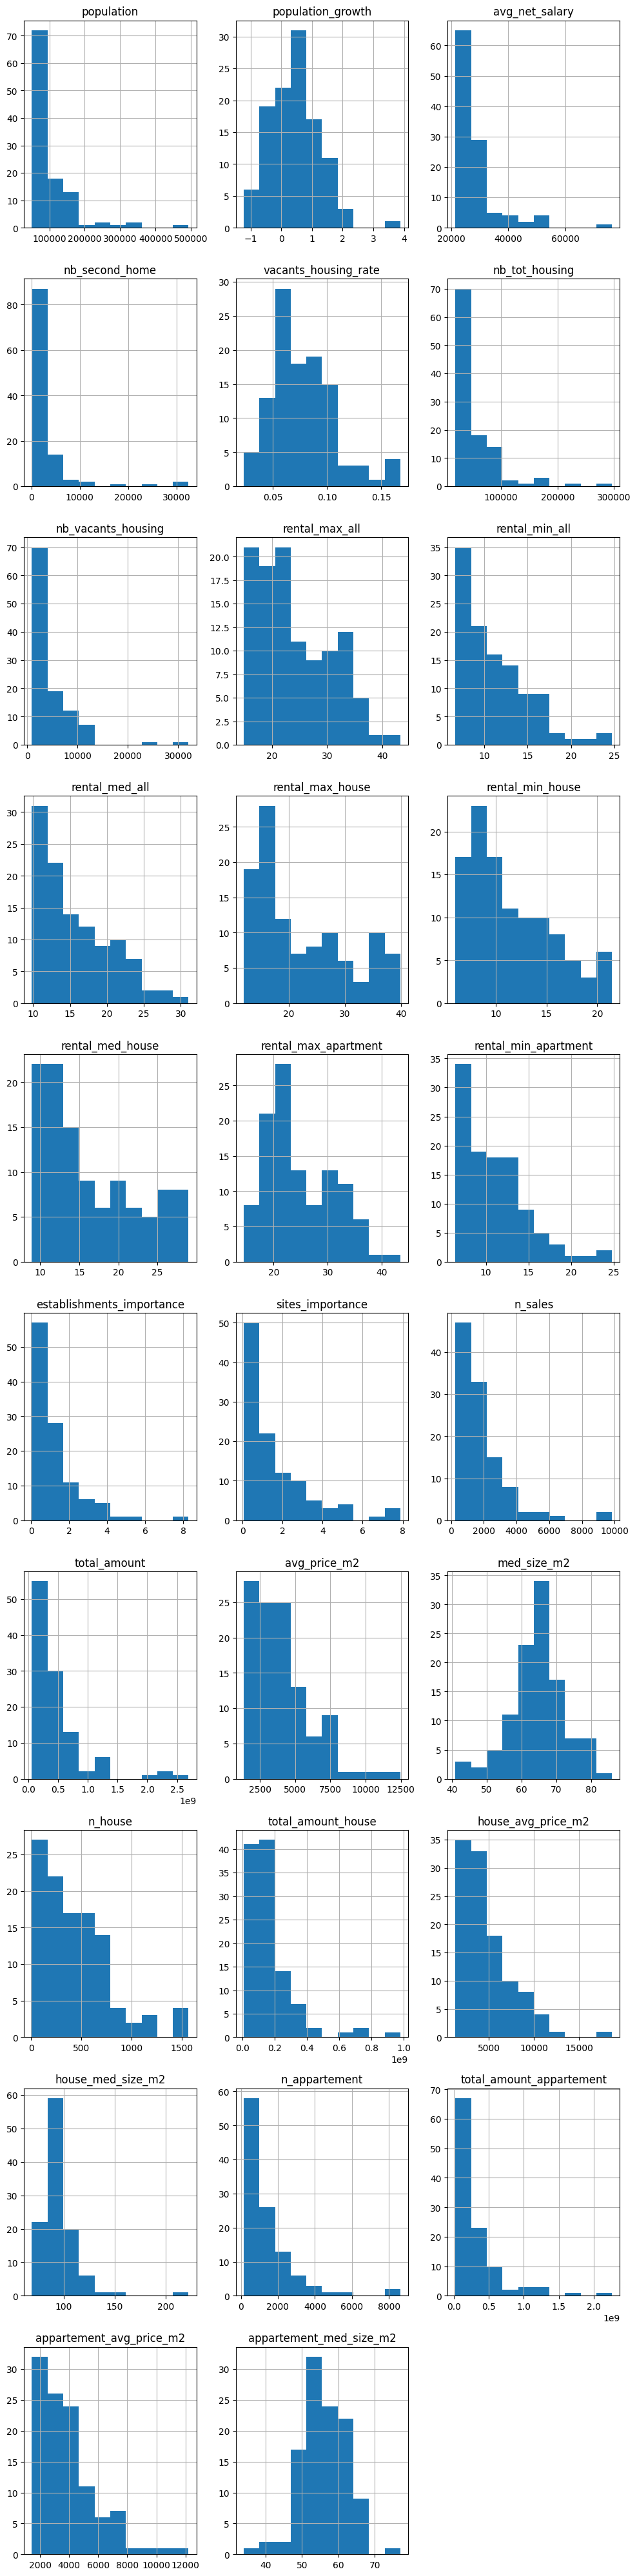

In [69]:
cols = modelo_clean.columns.to_list()

num_total = len(cols)
num_filas = (num_total - 1 // 3 + 1)

plt.rcParams['figure.figsize'] = [10, 4 * num_filas]  
fig, axes = plt.subplots(num_filas, 3)

for i, col in enumerate(cols):
    fila = i // 3
    columna = i % 3
    modelo_clean[col].hist(ax=axes[fila, columna])
    axes[fila, columna].set_title(col)

for i in range(num_total, num_filas * 3):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()

plt.rcParams['figure.figsize'] = [6.4, 4.8]

plt.show()

In [70]:
modelo_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110 entries, 02691 to 95585
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   population                 110 non-null    float64
 1   population_growth          110 non-null    float64
 2   avg_net_salary             110 non-null    float64
 3   nb_second_home             110 non-null    Int64  
 4   vacants_housing_rate       110 non-null    float64
 5   nb_tot_housing             110 non-null    Int64  
 6   nb_vacants_housing         110 non-null    Int64  
 7   rental_max_all             110 non-null    float64
 8   rental_min_all             110 non-null    float64
 9   rental_med_all             110 non-null    float64
 10  rental_max_house           110 non-null    float64
 11  rental_min_house           110 non-null    float64
 12  rental_med_house           110 non-null    float64
 13  rental_max_apartment       110 non-null    float6

In [71]:
modelo_clean.describe().round(2)

,population,population_growth,avg_net_salary,nb_second_home,vacants_housing_rate,nb_tot_housing,nb_vacants_housing,rental_max_all,rental_min_all,rental_med_all,...,avg_price_m2,med_size_m2,n_house,total_amount_house,house_avg_price_m2,house_med_size_m2,n_appartement,total_amount_appartement,appartement_avg_price_m2,appartement_med_size_m2
count,110.00,110.00,110.00,110.0,110.00,110.0,110.0,110.00,110.00,110.00,...,110.00,110.00,110.00,1.100000e+02,110.00,110.00,110.00,1.100000e+02,110.00,110.00
mean,99953.31,0.44,28712.19,2859.37,0.08,55361.65,4566.21,24.05,11.18,15.76,...,4057.56,64.48,439.79,1.704739e+08,4806.36,94.76,1408.07,3.058187e+08,3910.69,56.07
std,68144.07,0.79,7970.01,5133.29,0.03,42976.53,4435.16,6.64,3.81,4.81,...,2068.39,7.89,347.07,1.542483e+08,2863.16,18.15,1414.80,3.472424e+08,1979.47,6.35
min,50454.00,-1.23,21438.05,114.0,0.02,19368.0,939.0,14.85,6.71,9.83,...,1351.29,41.00,7.00,8.851898e+06,1267.30,69.00,153.00,2.162457e+07,1438.12,34.00
25%,59193.75,-0.06,24530.59,547.75,0.06,30451.0,1794.0,18.66,8.22,11.78,...,2466.50,60.00,166.00,7.585263e+07,2733.17,85.99,568.50,1.039425e+08,2471.76,52.99
50%,74760.50,0.47,26081.57,1314.0,0.07,38531.5,3112.0,21.86,10.25,14.48,...,3640.88,64.99,353.50,1.363065e+08,4114.93,91.26,916.50,1.794406e+08,3534.69,55.99
75%,115414.75,0.91,29150.00,2880.25,0.09,70445.75,6173.0,29.55,12.88,18.79,...,4835.50,68.01,629.75,2.012308e+08,5968.75,100.00,1800.25,3.508436e+08,4666.85,61.00
max,493465.00,3.88,76466.31,32423.0,0.17,296477.0,32036.0,43.31,24.72,31.04,...,12463.87,85.99,1570.00,9.782958e+08,18687.74,222.00,8620.00,2.263567e+09,12211.62,77.00


In [76]:
num_cols = modelo_clean.columns.to_list()
Q1 = modelo_clean[num_cols].quantile(0.25)
Q3 = modelo_clean[num_cols].quantile(0.75)
IQR =  Q3 - Q1 #rango intercuarltilico

out = round(((modelo_clean[num_cols] < (Q1 - 1.5 * IQR)) | (modelo_clean[num_cols] > (Q3 + 1.5 * IQR))).sum()/modelo_clean.shape[0]*100,0)
out = pd.DataFrame(out).reset_index()
out.columns = ['variables', 'outlier_count']
out = out.sort_values(by='outlier_count', ascending=False)
out

,variables,outlier_count
2,avg_net_salary,12.0
18,total_amount,10.0
26,total_amount_appartement,9.0
3,nb_second_home,8.0
16,sites_importance,7.0
25,n_appartement,6.0
22,total_amount_house,6.0
0,population,6.0
17,n_sales,5.0
23,house_avg_price_m2,5.0


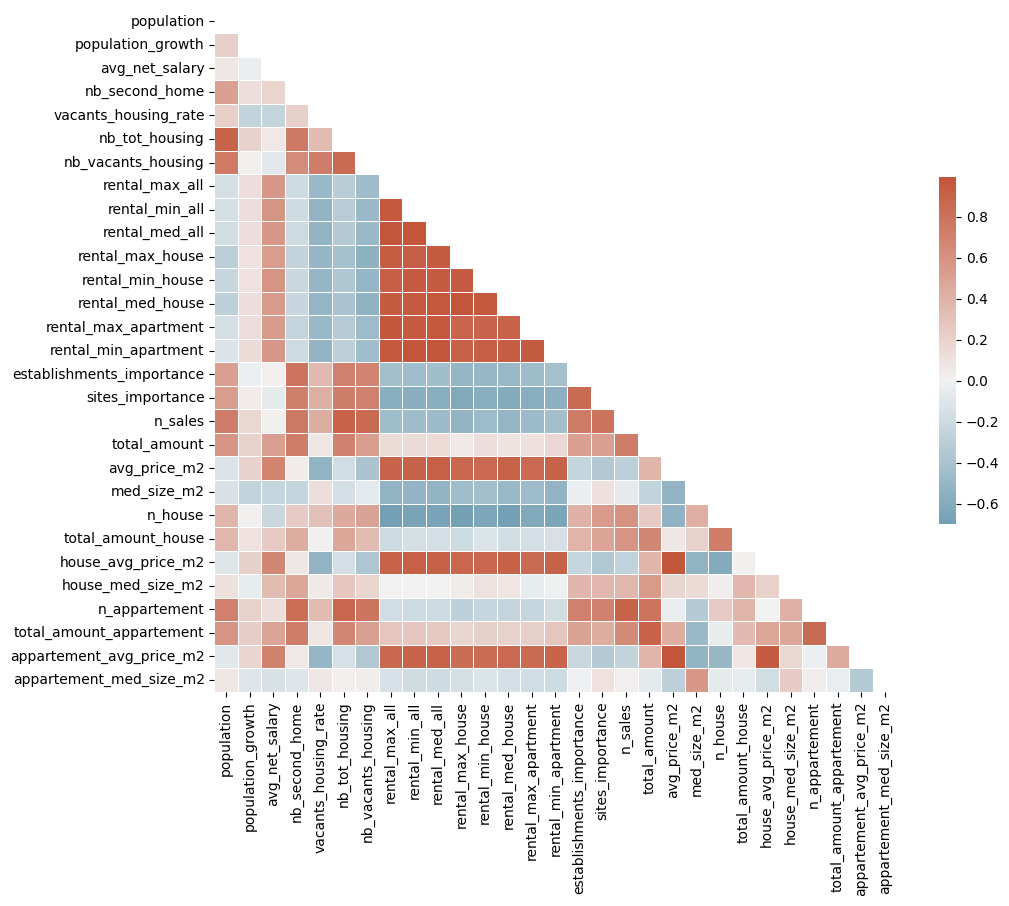

In [73]:
Corr = modelo_clean[num_cols].corr(method='spearman')

mask = np.triu(np.ones_like(Corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(Corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [74]:
# exportamos tabla con variables lista para calculo de ratios
modelo_clean.to_csv('modelo.csv')